In [1]:
# 定义全局函数便于直接调用处理
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTEENN, SMOTETomek
import numpy as np
import pandas as pd
from scipy.stats import boxcox
############目录定义#################################
datapath = 'D:/outsourcing/data/'
featurepath = 'D:/outsourcing/feature/'
resultpath = 'D:/outsourcing/result/'
tmppath = 'D:/outsourcing/tmp/'


###############函数定义################################
# reduce memory
def read_csv(file_name, num_rows=None):
    if num_rows is None:
        return pd.read_csv(file_name)
    return pd.read_csv(file_name, nrows=num_rows)


def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df


def evaluation(x_train, x_test, y_train, y_test, str):
    from sklearn.naive_bayes import GaussianNB
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.svm import SVC
    from sklearn.linear_model import LogisticRegression
    # knn = KNeighborsClassifier(n_neighbors=5, p=1)
    bayes = GaussianNB()
    tree = DecisionTreeClassifier()
    svm = SVC()
    LR = LogisticRegression()
    model_list = [bayes, tree, svm, LR]
    model_name = ['bayes', 'tree', 'svm', 'LR']
    f = open('../result/' + str + '.txt', mode='x')
    for i in range(len(model_list)):
        np.random.seed(0)
        model = model_list[i]
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        y_pred2 = model.predict(x_train)
        print("###################" + model_name[i] + "#########################", file=f)
        from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score, \
            accuracy_score, roc_auc_score, confusion_matrix
        print("balanced_accuracy_score=", balanced_accuracy_score(y_pred=y_pred, y_true=y_test),
              balanced_accuracy_score(y_pred=y_pred2, y_true=y_train), file=f)
        print("f1=", f1_score(y_pred=y_pred, y_true=y_test), f1_score(y_pred=y_pred2, y_true=y_train), file=f)
        print("precision_score=", precision_score(y_pred=y_pred, y_true=y_test),
              precision_score(y_pred=y_pred2, y_true=y_train), file=f)
        print("recall_score=", recall_score(y_pred=y_pred, y_true=y_test), recall_score(y_pred=y_pred2, y_true=y_train),
              file=f)
        print("accuracy=", accuracy_score(y_pred=y_pred, y_true=y_test), accuracy_score(y_pred=y_pred2, y_true=y_train),
              file=f)
        print("auc=", roc_auc_score(y_true=y_test, y_score=y_pred), roc_auc_score(y_true=y_train, y_score=y_pred2),
              file=f)
        print("#####混淆矩阵#########", file=f)
        print(confusion_matrix(y_true=y_test, y_pred=y_pred), confusion_matrix(y_true=y_train, y_pred=y_pred2), file=f)
    return
def getTrainTest(X, Y):
    global x_train, x_test, y_train, y_test
    # 会员编号等，等下仔细去查看所有取值数量超过100的特征
    from sklearn.model_selection import StratifiedKFold
    kfold = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    for train_index, test_index in kfold.split(X, Y):
        x_train = X.loc[train_index]
        x_test = X.loc[test_index]
        y_train = Y.loc[train_index]
        y_test = Y.loc[test_index]
        break
    return x_train, x_test, y_train, y_test


def getTrainTest_np(X, Y):
    global x_train, x_test, y_train, y_test
    # 会员编号等，等下仔细去查看所有取值数量超过100的特征
    from sklearn.model_selection import StratifiedKFold
    kfold = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    for train_index, test_index in kfold.split(X, Y):
        x_train = X[train_index]
        x_test = X[test_index]
        y_train = Y[train_index]
        y_test = Y[test_index]
        break
    return x_train, x_test, y_train, y_test


def minmax_target(X_train, X_test, Y_train, continue_list, discrete_list):
    import category_encoders as ce
    from sklearn.preprocessing import MinMaxScaler

    encoder = ce.LeaveOneOutEncoder(cols=discrete_list, drop_invariant=False).fit(X_train, Y_train)
    minmax = MinMaxScaler()
    train = pd.concat([X_train, X_test])
    minmax.fit(train[continue_list])

    X_train = encoder.transform(X_train)  # 基于训练集得到编码器
    X_test = encoder.transform(X_test)
    X_train[continue_list] = minmax.transform(X_train[continue_list])
    X_test[continue_list] = minmax.transform(X_test[continue_list])
    return X_train, X_test


def target(X_train, X_test, Y_train, discrete_list):
    import category_encoders as ce

    encoder = ce.LeaveOneOutEncoder(cols=discrete_list, drop_invariant=False).fit(X_train, Y_train)

    X_train = encoder.transform(X_train)  # 基于训练集得到编码器
    X_test = encoder.transform(X_test)
    return X_train, X_test


def minmax(X_train, X_test, continue_list):
    from sklearn.preprocessing import MinMaxScaler
    minmax = MinMaxScaler()
    train = pd.concat([X_train, X_test])
    minmax.fit(train[continue_list])
    X_train[continue_list] = minmax.transform(X_train[continue_list])
    X_test[continue_list] = minmax.transform(X_test[continue_list])
    return X_train, X_test

# sub_train数据集尝试

In [2]:
train = reduce_mem_usage(read_csv(tmppath + 'sub/BOX_Subtrain.csv'))
test = reduce_mem_usage(read_csv(tmppath + 'sub/BOX_Subtest.csv'))

X_train = train.drop(['emd_lable2'], axis=1)  # 去除部分取值过多的离散型特征
Y_train = train['emd_lable2'].astype(int)

discrete_list = ['seg_flight', 'seg_cabin', 'pref_orig_m6_2', 'pref_line_y1_2',
                 'pref_line_y1_3', 'pref_line_y2_2', 'pref_line_y2_3', 'pref_line_y3_3'
    , 'pref_line_y3_4', 'pref_line_y3_5', 'pref_aircraft_y3_3', 'pref_city_y1_2',
                 'pref_city_y3_4', 'pref_dest_city_m6', 'pref_dest_city_y3'
    , 'pref_month_y3_1', 'seg_dep_time_month']  # 训练中需要剔除的特征都是离散型的特征
feature_list = X_train.columns.tolist()
continue_list = list(set(feature_list) - set(discrete_list))

X_train, test = minmax_target(X_train, test, Y_train, continue_list, discrete_list)  # 离散值编码与连续特征归一化

del test, train
x_train, x_test, y_train, y_test = getTrainTest(X_train, Y_train)  # 线下验证，80%训练集，20%验证集

Memory usage after optimization is: 3.96 MB
Decreased by 50.8%
Memory usage after optimization is: 1.14 MB
Decreased by 50.0%


# lightGBM的首次尝试,.直接调用查看结果！
# AUC非常不错，但F1值却始终不高

The f1 of the train is: 0.9434569056250731 The auc of the train is 0.988135787225445
The f1 of the test is: 0.23920265780730895 The auc of the test is 0.7976733506220863
The confusion matrix result:
 [[4157  235]
 [ 223   72]]


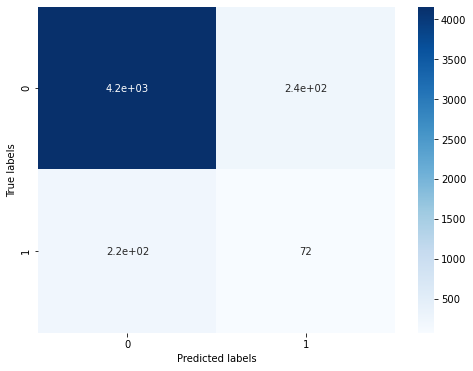

In [5]:
## 导入LightGBM模型
from lightgbm.sklearn import LGBMClassifier
## 定义 LightGBM 模型 
clf = LGBMClassifier()
# 在训练集上训练LightGBM模型
clf.fit(x_train, y_train)

## 在训练集和测试集上分布利用训练好的模型进行预测
train_predict = clf.predict(x_train)
test_predict = clf.predict(x_test)
from sklearn import metrics
## 利用f1评估模型效果
print('The f1 of the train is:',metrics.f1_score(y_train,train_predict),'The auc of the train is',metrics.roc_auc_score(y_train, clf.predict_proba(x_train)[:,1]))
print('The f1 of the test is:',metrics.f1_score(y_test,test_predict),'The auc of the test is',metrics.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]))


## 查看混淆矩阵 (预测值和真实值的各类情况统计矩阵)
confusion_matrix_result = metrics.confusion_matrix(y_test,test_predict)
print('The confusion matrix result:\n',confusion_matrix_result)

# 利用热力图对于结果进行可视化
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

0.000000 0.000000 1.985035
0.000000 0.003390 0.985035
0.000000 0.023729 0.926838
0.000228 0.023729 0.904411
0.000228 0.027119 0.857532
0.000911 0.027119 0.831880
0.000911 0.044068 0.793010
0.001138 0.044068 0.787617
0.001138 0.047458 0.767256
0.001366 0.047458 0.761513
0.001366 0.054237 0.757775
0.001821 0.054237 0.753785
0.001821 0.057627 0.747446
0.003643 0.057627 0.716852
0.003643 0.064407 0.714653
0.003871 0.064407 0.712733
0.003871 0.067797 0.708368
0.004098 0.067797 0.707848
0.004098 0.071186 0.706049
0.004554 0.071186 0.699560
0.005009 0.071186 0.699401
0.005009 0.074576 0.698589
0.005464 0.074576 0.695913
0.005692 0.074576 0.694179
0.005920 0.077966 0.692757
0.006603 0.077966 0.686870
0.007514 0.077966 0.684403
0.009563 0.077966 0.673489
0.009563 0.081356 0.673297
0.010474 0.081356 0.666927
0.010474 0.084746 0.665836
0.011840 0.084746 0.654005
0.011840 0.088136 0.653945
0.012295 0.088136 0.651924
0.012295 0.091525 0.650762
0.012978 0.091525 0.647781
0.012978 0.098305 0.647090
0

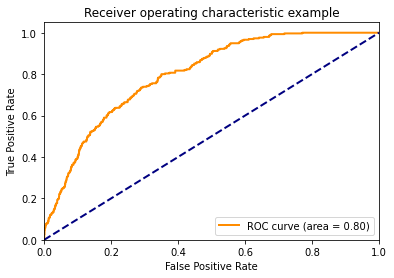

In [6]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import lightgbm as lgb
%matplotlib inline
from sklearn.model_selection import GridSearchCV
fpr, tpr, thersholds = roc_curve(y_test, clf.predict_proba(x_test)[:,1])
 
for i, value in enumerate(thersholds):
    print("%f %f %f" % (fpr[i], tpr[i], value))
 
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


# 具体细节调参步骤
## LightGBM 调参次序：
### 第一步：学习率和迭代次数n_estimators,learning_rate设置为较大的0.1
### 第二步：确定max_depth和num_leaves
### 第三步：确定min_data_in_leaf和max_bin in
### 第四步：确定feature_fraction、bagging_fraction、bagging_freq
### 第五步：确定lambda_l1和lambda_l2
### 第六步：确定 min_split_gain
### 第七步：降低学习率，增加迭代次数，验证模型


In [101]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

model = LGBMClassifier(boosting_type='gbdt',objective='binary',metrics='f1',
                        learning_rate=0.1, bagging_fraction = 0.8,feature_fraction = 0.8)
parameters={'n_estimators': range(300,3000,200)}
## 进行网格搜索
clf = GridSearchCV(model, parameters, cv=kfold, verbose=2)
clf = clf.fit(x_train, y_train)

## 在训练集和测试集上分布利用训练好的模型进行预测
train_predict = clf.predict(x_train)
test_predict = clf.predict(x_test)
from sklearn import metrics
print("最优参数:")
print(clf.best_params_)
## 利用f1评估模型效果
print('The f1 of the train is:',metrics.f1_score(y_train,train_predict),'The auc of the train is',metrics.roc_auc_score(y_train, clf.predict_proba(x_train)[:,1]))
print('The f1 of the test is:',metrics.f1_score(y_test,test_predict),'The auc of the test is',metrics.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]))


Fitting 10 folds for each of 14 candidates, totalling 140 fits
[CV] n_estimators=300 ................................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................. n_estimators=300, total=   0.7s
[CV] n_estimators=300 ................................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] ................................. n_estimators=300, total=   0.6s
[CV] n_estimators=300 ................................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................................. n_estimators=300, total=   0.6s
[CV] n_estimators=300 ................................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................................. n_estimators=300, total=   0.6s
[CV] n_estimators=300 ................................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Curr

[CV] ................................. n_estimators=700, total=   1.7s
[CV] n_estimators=700 ................................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................................. n_estimators=700, total=   2.1s
[CV] n_estimators=700 ................................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................................. n_estimators=700, total=   1.9s
[CV] n_estimators=700 ................................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Curr

[CV] ................................ n_estimators=1100, total=   2.4s
[CV] n_estimators=1100 ...............................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................................ n_estimators=1100, total=   2.2s
[CV] n_estimators=1100 ...............................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................................ n_estimators=1100, total=   2.2s
[CV] n_estimators=1100 ...............................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Curr

[CV] ................................ n_estimators=1500, total=   3.4s
[CV] n_estimators=1500 ...............................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................................ n_estimators=1500, total=   3.0s
[CV] n_estimators=1500 ...............................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................................ n_estimators=1500, total=   3.1s
[CV] n_estimators=1700 ...............................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Curr

[CV] ................................ n_estimators=1900, total=   5.1s
[CV] n_estimators=2100 ...............................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................................ n_estimators=2100, total=   4.6s
[CV] n_estimators=2100 ...............................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................................ n_estimators=2100, total=   7.0s
[CV] n_estimators=2100 ...............................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Curr

[CV] ................................ n_estimators=2500, total=   6.1s
[CV] n_estimators=2500 ...............................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................................ n_estimators=2500, total=   7.8s
[CV] n_estimators=2500 ...............................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................................ n_estimators=2500, total=   6.0s
[CV] n_estimators=2500 ...............................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Curr

[CV] ................................ n_estimators=2900, total=   5.6s
[CV] n_estimators=2900 ...............................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................................ n_estimators=2900, total=   5.5s
[CV] n_estimators=2900 ...............................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................................ n_estimators=2900, total=   5.8s
[CV] n_estimators=2900 ...............................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Curr

[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:  9.2min finished


最优参数:
{'n_estimators': 1300}
The f1 of the train is: 0.9746236559139785 The auc of the train is 0.9998830976469963
The f1 of the test is: 0.425531914893617 The auc of the test is 0.831619508505449


In [12]:
#n_estimator = 1300
model = LGBMClassifier(boosting_type='gbdt',objective='binary',metrics='f1',n_estimators=2200,
                        learning_rate=0.1, bagging_fraction = 0.8,feature_fraction = 0.8)
parameters={'max_depth': range(6,8,1), 'num_leaves':range(90, 130, 10)}
## 进行网格搜索
clf = GridSearchCV(model, parameters, cv=5, verbose=2)
clf = clf.fit(x_train, y_train)

## 在训练集和测试集上分布利用训练好的模型进行预测
train_predict = clf.predict(x_train)
test_predict = clf.predict(x_test)
from sklearn import metrics
print("最优参数:")
print(clf.best_params_)
## 利用f1评估模型效果
print('The f1 of the train is:',metrics.f1_score(y_train,train_predict),'The auc of the train is',metrics.roc_auc_score(y_train, clf.predict_proba(x_train)[:,1]))
print('The f1 of the test is:',metrics.f1_score(y_test,test_predict),'The auc of the test is',metrics.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] max_depth=6, num_leaves=100 .....................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... max_depth=6, num_leaves=100, total=  38.7s
[CV] max_depth=6, num_leaves=100 .....................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   38.6s remaining:    0.0s


[CV] ...................... max_depth=6, num_leaves=100, total=  35.2s
[CV] max_depth=6, num_leaves=100 .....................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ...................... max_depth=6, num_leaves=100, total=  34.8s
[CV] max_depth=6, num_leaves=100 .....................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ...................... max_depth=6, num_leaves=100, total=  44.6s
[CV] max_depth=6, num_leaves=100 .....................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Curr

[CV] ...................... max_depth=6, num_leaves=140, total=   7.1s
[CV] max_depth=6, num_leaves=140 .....................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ...................... max_depth=6, num_leaves=140, total=   8.8s
[CV] max_depth=6, num_leaves=150 .....................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ...................... max_depth=6, num_leaves=150, total=   7.0s
[CV] max_depth=6, num_leaves=150 .....................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Curr

[CV] ...................... max_depth=7, num_leaves=130, total=  11.9s
[CV] max_depth=7, num_leaves=130 .....................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ...................... max_depth=7, num_leaves=130, total=  11.4s
[CV] max_depth=7, num_leaves=130 .....................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ...................... max_depth=7, num_leaves=130, total=  11.9s
[CV] max_depth=7, num_leaves=130 .....................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Curr

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 13.6min finished


最优参数:
{'max_depth': 7, 'num_leaves': 110}
The f1 of the train is: 0.9983318953120506 The auc of the train is 0.9999919993280693
The f1 of the test is: 0.39278557114228463 The auc of the test is 0.8203401407798463


In [16]:
model = LGBMClassifier(boosting_type='gbdt',objective='binary',n_estimators=2200,max_depth=7,num_leaves=110,metrics='f1',
                        learning_rate=0.1, bagging_fraction = 0.8,feature_fraction = 0.8)
parameters={'max_bin': range(100,500,50),'min_data_in_leaf':range(50,150,10)}
## 进行网格搜索
clf = GridSearchCV(model, parameters, cv=3, verbose=2)
clf = clf.fit(x_train, y_train)

## 在训练集和测试集上分布利用训练好的模型进行预测
train_predict = clf.predict(x_train)
test_predict = clf.predict(x_test)
from sklearn import metrics
print("最优参数:")
print(clf.best_params_)
## 利用f1评估模型效果
print('The f1 of the train is:',metrics.f1_score(y_train,train_predict),'The auc of the train is',metrics.roc_auc_score(y_train, clf.predict_proba(x_train)[:,1]))
print('The f1 of the test is:',metrics.f1_score(y_test,test_predict),'The auc of the test is',metrics.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]))


Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV] max_bin=100, min_data_in_leaf=50 ................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. max_bin=100, min_data_in_leaf=50, total=   6.0s
[CV] max_bin=100, min_data_in_leaf=50 ................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s


[CV] ................. max_bin=100, min_data_in_leaf=50, total=   5.1s
[CV] max_bin=100, min_data_in_leaf=50 ................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................. max_bin=100, min_data_in_leaf=50, total=   7.7s
[CV] max_bin=100, min_data_in_leaf=60 ................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] ................ max_bin=100, min_data_in_leaf=110, total=   7.5s
[CV] max_bin=100, min_data_in_leaf=110 ...............................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................ max_bin=100, min_data_in_leaf=110, total=   7.3s
[CV] max_bin=100, min_data_in_leaf=110 ...............................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging

[CV] ................. max_bin=150, min_data_in_leaf=60, total=  10.1s
[CV] max_bin=150, min_data_in_leaf=70 ................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................. max_bin=150, min_data_in_leaf=70, total=  11.9s
[CV] max_bin=150, min_data_in_leaf=70 ................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] ................ max_bin=150, min_data_in_leaf=120, total=   6.6s
[CV] max_bin=150, min_data_in_leaf=120 ...............................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................ max_bin=150, min_data_in_leaf=120, total=   6.9s
[CV] max_bin=150, min_data_in_leaf=130 ...............................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging

[CV] ................. max_bin=200, min_data_in_leaf=80, total=   8.4s
[CV] max_bin=200, min_data_in_leaf=80 ................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................. max_bin=200, min_data_in_leaf=80, total=   8.6s
[CV] max_bin=200, min_data_in_leaf=80 ................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] ................ max_bin=200, min_data_in_leaf=130, total=   6.5s
[CV] max_bin=200, min_data_in_leaf=140 ...............................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................ max_bin=200, min_data_in_leaf=140, total=   6.1s
[CV] max_bin=200, min_data_in_leaf=140 ...............................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging

[CV] ................. max_bin=250, min_data_in_leaf=90, total=   7.2s
[CV] max_bin=250, min_data_in_leaf=90 ................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................. max_bin=250, min_data_in_leaf=90, total=   7.5s
[CV] max_bin=250, min_data_in_leaf=100 ...............................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_f

[CV] ................. max_bin=300, min_data_in_leaf=50, total=   7.9s
[CV] max_bin=300, min_data_in_leaf=50 ................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................. max_bin=300, min_data_in_leaf=50, total=   9.1s
[CV] max_bin=300, min_data_in_leaf=50 ................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] ................ max_bin=300, min_data_in_leaf=100, total=   7.4s
[CV] max_bin=300, min_data_in_leaf=110 ...............................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................ max_bin=300, min_data_in_leaf=110, total=   6.8s
[CV] max_bin=300, min_data_in_leaf=110 ...............................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging

[CV] ................. max_bin=350, min_data_in_leaf=60, total=   9.5s
[CV] max_bin=350, min_data_in_leaf=60 ................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................. max_bin=350, min_data_in_leaf=60, total=   9.6s
[CV] max_bin=350, min_data_in_leaf=70 ................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] ................ max_bin=350, min_data_in_leaf=120, total=   7.4s
[CV] max_bin=350, min_data_in_leaf=120 ...............................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................ max_bin=350, min_data_in_leaf=120, total=   7.3s
[CV] max_bin=350, min_data_in_leaf=120 ...............................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging

[CV] ................. max_bin=400, min_data_in_leaf=70, total=  10.4s
[CV] max_bin=400, min_data_in_leaf=80 ................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................. max_bin=400, min_data_in_leaf=80, total=   9.3s
[CV] max_bin=400, min_data_in_leaf=80 ................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] ................ max_bin=400, min_data_in_leaf=130, total=   9.9s
[CV] max_bin=400, min_data_in_leaf=130 ...............................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................ max_bin=400, min_data_in_leaf=130, total=  10.0s
[CV] max_bin=400, min_data_in_leaf=140 ...............................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging

[CV] ................. max_bin=450, min_data_in_leaf=90, total=   9.7s
[CV] max_bin=450, min_data_in_leaf=90 ................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] ................. max_bin=450, min_data_in_leaf=90, total=  11.7s
[CV] max_bin=450, min_data_in_leaf=90 ................................
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] ................ max_bin=450, min_data_in_leaf=140, total=  10.6s
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 33.5min finished


最优参数:
{'max_bin': 150, 'min_data_in_leaf': 80}
The f1 of the train is: 0.9976427298338413 The auc of the train is 0.9999760178246836
The f1 of the test is: 0.3923809523809524 The auc of the test is 0.8069463739927758


In [21]:
model = LGBMClassifier(boosting_type='gbdt',objective='binary',n_estimators=2200,max_depth=7,num_leaves=110,metrics='f1',
                        learning_rate=0.1)
parameters={  'feature_fraction': [0.9,1.0,1.1,1.2,1.3],
              'bagging_fraction': [0.8,0.9,1.0],
              'bagging_freq': range(3,4,5)
            }
## 进行随机网格搜索，加快速度
from sklearn.model_selection import RandomizedSearchCV
clf = RandomizedSearchCV(model, parameters, cv=5, verbose=2,scoring='f1')
clf = clf.fit(x_train, y_train)

## 在训练集和测试集上分布利用训练好的模型进行预测
train_predict = clf.predict(x_train)
test_predict = clf.predict(x_test)
from sklearn import metrics
print("最优参数:")
print(clf.best_params_)
## 利用f1评估模型效果
print('The f1 of the train is:',metrics.f1_score(y_train,train_predict),'The auc of the train is',metrics.roc_auc_score(y_train, clf.predict_proba(x_train)[:,1]))
print('The f1 of the test is:',metrics.f1_score(y_test,test_predict),'The auc of the test is',metrics.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] feature_fraction=1.0, bagging_freq=3, bagging_fraction=0.9 ......
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  feature_fraction=1.0, bagging_freq=3, bagging_fraction=0.9, total=   9.7s
[CV] feature_fraction=1.0, bagging_freq=3, bagging_fraction=0.9 ......
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.6s remaining:    0.0s


[CV]  feature_fraction=1.0, bagging_freq=3, bagging_fraction=0.9, total=  13.4s
[CV] feature_fraction=1.0, bagging_freq=3, bagging_fraction=0.9 ......
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[CV]  feature_fraction=1.0, bagging_freq=3, bagging_fraction=0.9, total=  13.2s
[CV] feature_fraction=1.0, bagging_freq=3, bagging_fraction=0.9 ......
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[CV]  feature_fraction=0.9, bagging_freq=3, bagging_fraction=0.8, total=  12.1s
[CV] feature_fraction=0.9, bagging_freq=3, bagging_fraction=0.8 ......
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[CV]  feature_fraction=0.9, bagging_freq=3, bagging_fraction=0.8, total=  13.1s
[CV] feature_fraction=0.9, bagging_freq=3, bagging_fraction=0.8 ......
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[LightGBM] [Warning] feature_fraction is set=1.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[CV]  feature_fraction=1.1, bagging_freq=3, bagging_fraction=0.8, total=   0.0s
[CV] feature_fraction=1.1, bagging_freq=3, bagging_fraction=0.8 ......
[LightGBM] [Warning] feature_fraction is set=1.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[CV]  feature_fraction=1.1, bagging_freq=3, bagging_fraction=0.8, total=   0.0s
[CV] feature_fraction=0.9, bagging_freq=3, bagging_fraction=0.9 ......


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.3min finished


最优参数:
{'feature_fraction': 1.0, 'bagging_freq': 3, 'bagging_fraction': 0.9}
The f1 of the train is: 0.9983321831147919 The auc of the train is 0.9999877799201818
The f1 of the test is: 0.40480961923847697 The auc of the test is 0.8271854064400606


In [23]:
model = LGBMClassifier(boosting_type='gbdt',objective='binary',n_estimators=2200,max_depth=7,num_leaves=110,metrics='f1',
                        learning_rate=0.1,
                     feature_fraction= 1.0, bagging_freq=3, bagging_fraction= 0.9 )
parameters={'lambda_l1': [1e-5,1e-3,1e-1,0.0,0.1,0.3,0.5,0.7,0.9,1.0],
              'lambda_l2': [1e-5,1e-3,1e-1,0.0,0.1,0.3,0.5,0.7,0.9,1.0]
}

## 进行网格搜索
clf = RandomizedSearchCV(model, parameters, cv=5, verbose=2,scoring='f1')
clf = clf.fit(x_train, y_train)

## 在训练集和测试集上分布利用训练好的模型进行预测
train_predict = clf.predict(x_train)
test_predict = clf.predict(x_test)
from sklearn import metrics
print("最优参数:")
print(clf.best_params_)
## 利用f1评估模型效果
print('The f1 of the train is:',metrics.f1_score(y_train,train_predict),'The auc of the train is',metrics.roc_auc_score(y_train, clf.predict_proba(x_train)[:,1]))
print('The f1 of the test is:',metrics.f1_score(y_test,test_predict),'The auc of the test is',metrics.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] lambda_l2=0.1, lambda_l1=1e-05 ..................................
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=1e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1e-05
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... lambda_l2=0.1, lambda_l1=1e-05, total=  12.8s
[CV] lambda_l2=0.1, lambda_l1=1e-05 ..................................
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=1e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1e-05
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.7s remaining:    0.0s


[CV] ................... lambda_l2=0.1, lambda_l1=1e-05, total=  15.2s
[CV] lambda_l2=0.1, lambda_l1=1e-05 ..................................
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=1e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1e-05
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[CV] ................... lambda_l2=0.1, lambda_l1=1e-05, total=  14.9s
[CV] lambda_l2=0.1, lambda_l1=1e-05 ..................................
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 i

[CV] ..................... lambda_l2=0.7, lambda_l1=0.3, total=  16.2s
[CV] lambda_l2=0.7, lambda_l1=0.3 ....................................
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[CV] ..................... lambda_l2=0.7, lambda_l1=0.3, total=  15.9s
[CV] lambda_l2=0.5, lambda_l1=1.0 ....................................
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is se

[CV] ..................... lambda_l2=0.9, lambda_l1=0.0, total=  25.4s
[CV] lambda_l2=0.9, lambda_l1=0.0 ....................................
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.9, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[CV] ..................... lambda_l2=0.9, lambda_l1=0.0, total=  19.3s
[CV] lambda_l2=0.9, lambda_l1=0.0 ....................................
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is se

[CV] ................... lambda_l2=0.1, lambda_l1=1e-05, total=  19.3s
[CV] lambda_l2=0.1, lambda_l1=1e-05 ..................................
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=1e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1e-05
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[CV] ................... lambda_l2=0.1, lambda_l1=1e-05, total=  23.5s
[CV] lambda_l2=0.1, lambda_l1=1e-05 ..................................
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 i

[CV] ..................... lambda_l2=0.1, lambda_l1=0.0, total=  16.4s
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 15.3min finished


最优参数:
{'lambda_l2': 0.001, 'lambda_l1': 0.0}
The f1 of the train is: 0.9983321831147919 The auc of the train is 0.9999884214289045
The f1 of the test is: 0.40954274353876735 The auc of the test is 0.826969297026952


In [32]:
model = LGBMClassifier(boosting_type='gbdt',objective='binary',
                       n_estimators=2200,
                       max_depth=7,num_leaves=110,
                        learning_rate=0.1,
                      lambda_l1=0.0,lambda_l2=1e-03,
                     feature_fraction= 1.0, bagging_freq=3, bagging_fraction= 0.9 )

parameters={'min_split_gain':[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]}

## 进行网格搜索
clf = RandomizedSearchCV(model, parameters, cv=5, verbose=2,scoring='f1')
clf = clf.fit(x_train, y_train)

## 在训练集和测试集上分布利用训练好的模型进行预测
train_predict = clf.predict(x_train)
test_predict = clf.predict(x_test)
from sklearn import metrics
print("最优参数:")
print(clf.best_params_)
## 利用f1评估模型效果
print('The f1 of the train is:',metrics.f1_score(y_train,train_predict),'The auc of the train is',metrics.roc_auc_score(y_train, clf.predict_proba(x_train)[:,1]))
print('The f1 of the test is:',metrics.f1_score(y_test,test_predict),'The auc of the test is',metrics.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] min_split_gain=0.6 ..............................................
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................... min_split_gain=0.6, total=   2.6s
[CV] min_split_gain=0.6 ..............................................
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


KeyboardInterrupt: 

In [36]:
# 第七步：降低学习率，增加迭代次数，验证模型
model = LGBMClassifier(boosting_type='gbdt',objective='binary',
                       n_estimators=2200,
                       max_depth=7,num_leaves=110,
                        learning_rate=0.1,
                      lambda_l1=0.0,lambda_l2=1e-03,min_split_gain=0.0,
                     feature_fraction= 1.0,bagging_freq=3, bagging_fraction= 0.9)



model.fit(x_train, y_train)
test_predict = model.predict(x_test)
f1_test =metrics.f1_score(y_test,test_predict)

print("LightGBM learning rate 0.1 f1 Score:   ", f1_test)

model = LGBMClassifier(boosting_type='gbdt',objective='binary',
                       n_estimators=2200,
                       max_depth=7,num_leaves=110,
                        learning_rate=0.05,
                       lambda_l1=0.0,lambda_l2=1e-03,min_split_gain=0.0,
                     feature_fraction= 1.0, bagging_freq=3, bagging_fraction= 0.9)

model.fit(x_train, y_train)
test_predict = model.predict(x_test)
f1_test =metrics.f1_score(y_test,test_predict)

print("LightGBM learning rate 0.05 f1 Score:   ", f1_test)

model = LGBMClassifier(boosting_type='gbdt',objective='binary',
                       n_estimators=2200,
                       max_depth=7,num_leaves=110,
                        learning_rate=0.01,
                       lambda_l1=0.0,lambda_l2=1e-03,min_split_gain=0.0,
                     feature_fraction= 1.0, bagging_freq=3, bagging_fraction= 0.9)

model.fit(x_train, y_train)
test_predict = model.predict(x_test)
f1_test =metrics.f1_score(y_test,test_predict)

print("LightGBM learning rate 0.01 f1 Score:   ", f1_test)

model = LGBMClassifier(boosting_type='gbdt',objective='binary',
                       n_estimators=2200,
                       max_depth=7,num_leaves=110,
                        learning_rate=0.005,
                       lambda_l1=0.0,lambda_l2=1e-03,min_split_gain=0.0,
                     feature_fraction= 1.0, bagging_freq=3, bagging_fraction= 0.9)

model.fit(x_train, y_train)
test_predict = model.predict(x_test)
f1_test =metrics.f1_score(y_test,test_predict)

print("LightGBM learning rate 0.005 f1 Score:   ", f1_test)

LightGBM learning rate 0.1 f1 Score:    0.40954274353876735
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
LightGBM learning rate 0.05 f1 Score:    0.4008264462809918
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current valu

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
The f1 of the train is: 0.9782330345710628 The auc of the train is 0.9999277260731327
The f1 of the test is: 0.4189189189189189 The auc of the test is 0.8342807415640147
The confusion matrix result:
 [[4336   56]
 [ 202   93]]


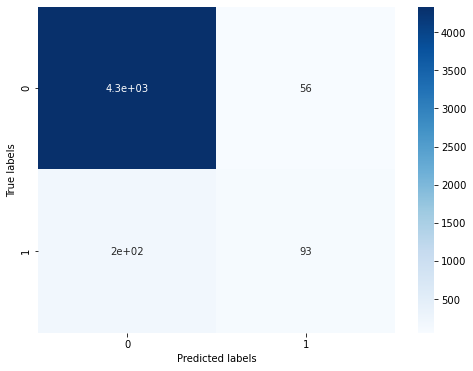

In [3]:
## 导入LightGBM模型
from lightgbm.sklearn import LGBMClassifier
## 定义 LightGBM 模型 
clf = LGBMClassifier(boosting_type='gbdt',objective='binary',
                       n_estimators=2200,
                       max_depth=7,num_leaves=110,
                        learning_rate=0.1,
                      lambda_l1=0.0,lambda_l2=1e-03,min_split_gain=0.0,
                     feature_fraction= 1.0,bagging_freq=3, bagging_fraction= 0.9)
# 在训练集上训练LightGBM模型
clf.fit(x_train, y_train)

## 在训练集和测试集上分布利用训练好的模型进行预测
train_predict = clf.predict(x_train)
test_predict = clf.predict(x_test)
from sklearn import metrics
## 利用f1评估模型效果
print('The f1 of the train is:',metrics.f1_score(y_train,train_predict),'The auc of the train is',metrics.roc_auc_score(y_train, clf.predict_proba(x_train)[:,1]))
print('The f1 of the test is:',metrics.f1_score(y_test,test_predict),'The auc of the test is',metrics.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]))


## 查看混淆矩阵 (预测值和真实值的各类情况统计矩阵)
confusion_matrix_result = metrics.confusion_matrix(y_test,test_predict)
print('The confusion matrix result:\n',confusion_matrix_result)

# 利用热力图对于结果进行可视化
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()